In [6]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import json

# =============================================================================
# PART 1: CONFIGURATION
# =============================================================================
print("--- Part 1: Configuration ---")

# --- Configure Matplotlib ---
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="ticks", context="talk", font_scale=1.0)

--- Part 1: Configuration ---


In [7]:
# --- Define Paths ---
BASE_MODELS_DIR = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Models/optuna_models"

# Output Directories
BASE_OUTPUT_DIR = "UMAP_Analysis"
DATA_DIR = os.path.join(BASE_OUTPUT_DIR, "Data")
FIGS_DIR = os.path.join(BASE_OUTPUT_DIR, "Figs")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)

# --- List of Specific Drug-Target Pairs ---
specific_pairs = [
    {'drug_name': 'DAPORINAD', 'target': 'NAMPT'}, 
    {'drug_name': 'AZD8931', 'target': 'ERBB2'},
    {'drug_name': 'BMS-754807', 'target': 'IGF1R'}, 
    {'drug_name': 'DABRAFENIB', 'target': 'BRAF'},
    {'drug_name': 'IMATINIB', 'target': 'MCL1'}, 
    {'drug_name': 'MK-2206', 'target': 'AKT1'},
    {'drug_name': 'TIVANTINIB', 'target': 'MET'}, 
    {'drug_name': 'ULIXERTINIB', 'target': 'MAPK1'}, 
    {'drug_name': 'UPROSERTIB', 'target': 'AKT1'}, 
    {'drug_name': 'TIVOZANIB', 'target': 'PDGFRB'}
]

In [8]:
# =============================================================================
# PART 2: FIND THE "SUPER-COMMON" SET OF CELL LINES
# =============================================================================
print("\n" + "="*80)
print("Part 2: Identifying 'Super-Common' cell lines across all models...")

# We need to peek into every model to see which cell lines it was trained/tested on,
# and intersect that with the available expression data.

sets_of_valid_cells = []
cached_exp_paths = {} # To map model to exp path to avoid repeated loading later if possible

# Helper to load model
def load_model(drug, target):
    fname = f"{drug}_{target}_forgeModel_optuna100.pkl"
    fpath = os.path.join(BASE_MODELS_DIR, fname)
    if not os.path.exists(fpath):
        return None
    with open(fpath, "rb") as f:
        return pickle.load(f)

# 1. First pass: Collect cell line sets
# We need to load the expression dataframe at least once to check indices
global_exp_index = None

for pair in tqdm(specific_pairs, desc="Checking Model Scopes"):
    drug = pair['drug_name']
    target = pair['target']
    
    model = load_model(drug, target)
    if model is None:
        print(f"Skipping {drug}: Model file not found.")
        continue
        
    # If this is the first time, load the expression index
    if global_exp_index is None:
        print(f"   Loading expression index from {model.exp_path}...")
        # Read only index to save memory
        temp_df = pd.read_csv(model.exp_path, index_col=0, usecols=[0]) 
        global_exp_index = set(temp_df.index)

    # Union of Train and Test lines for this model
    model_cells = set(model.train_cellLines) | set(model.test_cellLines)
    
    # Intersection with available expression data
    valid_cells = model_cells & global_exp_index
    sets_of_valid_cells.append(valid_cells)

if not sets_of_valid_cells:
    print("CRITICAL ERROR: No valid models found.")
    exit()

# Find intersection across ALL models
super_common_set = set.intersection(*sets_of_valid_cells)
super_common_cell_lines = sorted(list(super_common_set))

if len(super_common_cell_lines) < 20:
    print(f"\nCRITICAL ERROR: Only found {len(super_common_cell_lines)} common cell lines.")
    exit()

print(f"✅ Found {len(super_common_cell_lines)} 'super-common' cell lines used for comparison.")

# Save common cell lines
with open(os.path.join(DATA_DIR, "common_cell_lines_across_drugs.pkl"), "wb") as f:
    pickle.dump(super_common_cell_lines, f)


Part 2: Identifying 'Super-Common' cell lines across all models...


Checking Model Scopes:   0%|          | 0/10 [00:00<?, ?it/s]

   Loading expression index from /home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/Fresh_FORGE/Data/Exp.csv...


Checking Model Scopes: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]

✅ Found 170 'super-common' cell lines used for comparison.


In [9]:
# =============================================================================
# PART 3: GENERATE LATENT VECTORS & APPLY INDEPENDENT PCA
# =============================================================================
print("\n" + "="*80)
print("Part 3: Projecting data, Scaling, and Applying PCA (10 comps)...")

all_latent_vectors_pca = []
all_labels = []
cached_exp_df = None
current_exp_path = None

# Define target dimensions for PCA
TARGET_PCA_COMPONENTS = 10

for pair in tqdm(specific_pairs, desc="Processing Models"):
    drug = pair['drug_name']
    target = pair['target']
    pair_label = f"{drug}-{target}"
    
    model = load_model(drug, target)
    if model is None: continue

    # 1. Load Expression (Cached)
    if model.exp_path != current_exp_path:
        full_exp_df = pd.read_csv(model.exp_path, index_col=0)
        full_exp_df = full_exp_df[~full_exp_df.index.duplicated(keep='first')]
        cached_exp_df = full_exp_df
        current_exp_path = model.exp_path
    
    # 2. Subset Data
    try:
        E_subset = cached_exp_df.loc[super_common_cell_lines, model.hcg_list]
        G = E_subset.to_numpy()
    except KeyError as e:
        print(f"   Error: Missing genes/cells for {drug}. {e}")
        continue
        
    # 3. Calculate Raw Latent Z
    if G.shape[1] != model.W.shape[0]:
        print(f"   Shape mismatch for {drug}. Skipping.")
        continue
        
    Z_raw = G @ model.W
    
    # 4. Standard Scale per model (Crucial before PCA)
    # We standardize each model independently so PCA finds variance, not magnitude.
    scaler = StandardScaler()
    Z_scaled = scaler.fit_transform(Z_raw)

    # 5. Apply PCA to reduce/standardize to 10 components
    # Check if model has enough dimensions
    if Z_scaled.shape[1] < TARGET_PCA_COMPONENTS:
        print(f"   ⚠️ WARNING: {drug} has only {Z_scaled.shape[1]} latent factors. Padding to {TARGET_PCA_COMPONENTS}.")
        # Fallback: Use all available, then zero-pad the rest to reach 10
        pca = PCA(n_components=Z_scaled.shape[1])
        Z_reduced = pca.fit_transform(Z_scaled)
        # Pad remaining columns with 0
        pad_width = TARGET_PCA_COMPONENTS - Z_scaled.shape[1]
        Z_final = np.pad(Z_reduced, ((0,0), (0, pad_width)), mode='constant')
    else:
        # Standard case: Reduce 50 -> 10, or 25 -> 10
        pca = PCA(n_components=TARGET_PCA_COMPONENTS)
        Z_final = pca.fit_transform(Z_scaled)
    
    # Store
    all_latent_vectors_pca.append(Z_final)
    all_labels.extend([pair_label] * len(super_common_cell_lines))

if not all_latent_vectors_pca:
    print("No latent vectors generated.")
    exit()

# 6. Stack
combined_Z = np.vstack(all_latent_vectors_pca)
print(f"✅ Combined Latent Matrix Shape: {combined_Z.shape}") 
# Expected shape: (Total_Samples, 10)


Part 3: Projecting data, Scaling, and Applying PCA (10 comps)...


Processing Models: 100%|██████████| 10/10 [01:36<00:00,  9.67s/it]

✅ Combined Latent Matrix Shape: (1700, 10)



Part 4: Running UMAP on PCA-reduced data...
   Running UMAP...


/home/nilabjab/miniconda3/envs/pyenv3.10/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Part 5: Plotting...


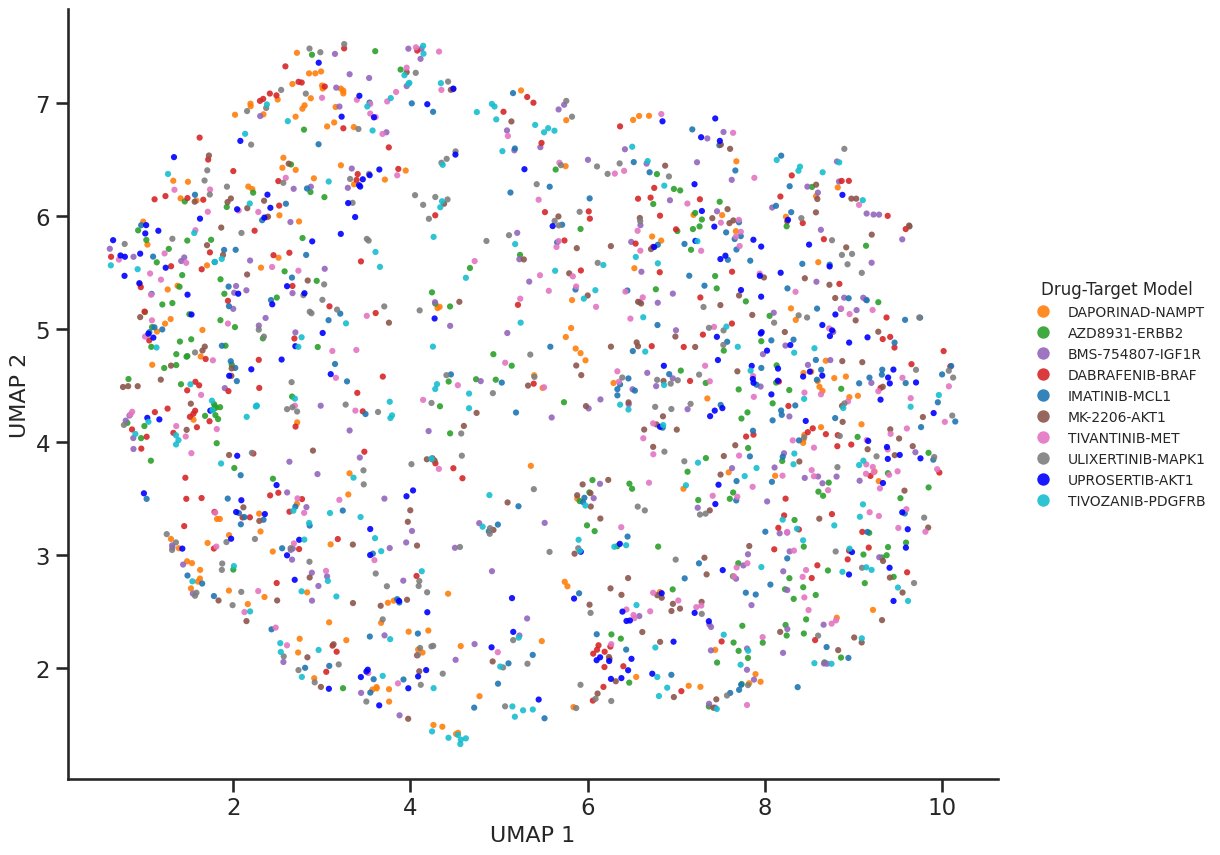


Done.


In [12]:
# =============================================================================
# PART 4: UMAP ON PCA-REDUCED DATA
# =============================================================================
print("\n" + "="*80)
print("Part 4: Running UMAP on PCA-reduced data...")

# Note: The data is already locally scaled and PCA'd. 
# We can run UMAP directly, or normalize the whole stack again. 
# Usually, running UMAP directly on the PCA output is fine, 
# but a final Z-score across the whole stack ensures global comparability.


# Save intermediate
#np.save(os.path.join(DATA_DIR, "combined_Z_pca10.npy"), combined_Z)
#pd.Series(all_labels).to_csv(os.path.join(DATA_DIR, "model_labels.csv"), index=False)

# UMAP
print("   Running UMAP...")
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    metric='cosine' # Cosine is often good for high-dim latent spaces
)
embedding = reducer.fit_transform(combined_Z)

umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
#umap_df.to_csv(os.path.join(DATA_DIR, "umap_embedding_coordinates.csv"), index=False)


# =============================================================================
# PART 5: VISUALIZATION
# =============================================================================
print("\n" + "="*80)
print("Part 5: Plotting...")

plot_df = umap_df.copy()
plot_df['Model'] = all_labels

unique_labels = plot_df['Model'].unique()
# Custom colors (High contrast)
custom_colors = [
    "#ff7e0d", "#2ba02b", "#9466bc", "#d62627", 
    "#1e76b3", "#8c554b", "#e375c2", "#7e7e7e", 
    "#0000ff", "#17becf"
]
import itertools
palette = dict(zip(unique_labels, itertools.cycle(custom_colors)))

fig, ax = plt.subplots(figsize=(12, 10))

scatter = sns.scatterplot(
    data=plot_df,
    x='UMAP1',
    y='UMAP2',
    hue='Model',
    palette=palette,
    s=20,
    alpha=0.9,
    edgecolor='none',
    ax=ax
)
for coll in ax.collections:
    coll.set_rasterized(True)

ax.set_xlabel('UMAP 1', fontsize=16)
ax.set_ylabel('UMAP 2', fontsize=16)
sns.despine(top=True, right=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title="Drug-Target Model",
    title_fontsize=12,
    fontsize=10,
    markerscale=2,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)


plt.savefig("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/Comparative_UMAP.pdf", dpi=600, bbox_inches='tight')
plt.show()

print("\nDone.")


Part 4: Running t-SNE on PCA-reduced data...
   Running t-SNE...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1700 samples in 0.000s...
[t-SNE] Computed neighbors for 1700 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1700
[t-SNE] Computed conditional probabilities for sample 1700 / 1700
[t-SNE] Mean sigma: 0.125774


/home/nilabjab/miniconda3/envs/pyenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.083679
[t-SNE] KL divergence after 1000 iterations: 1.973436


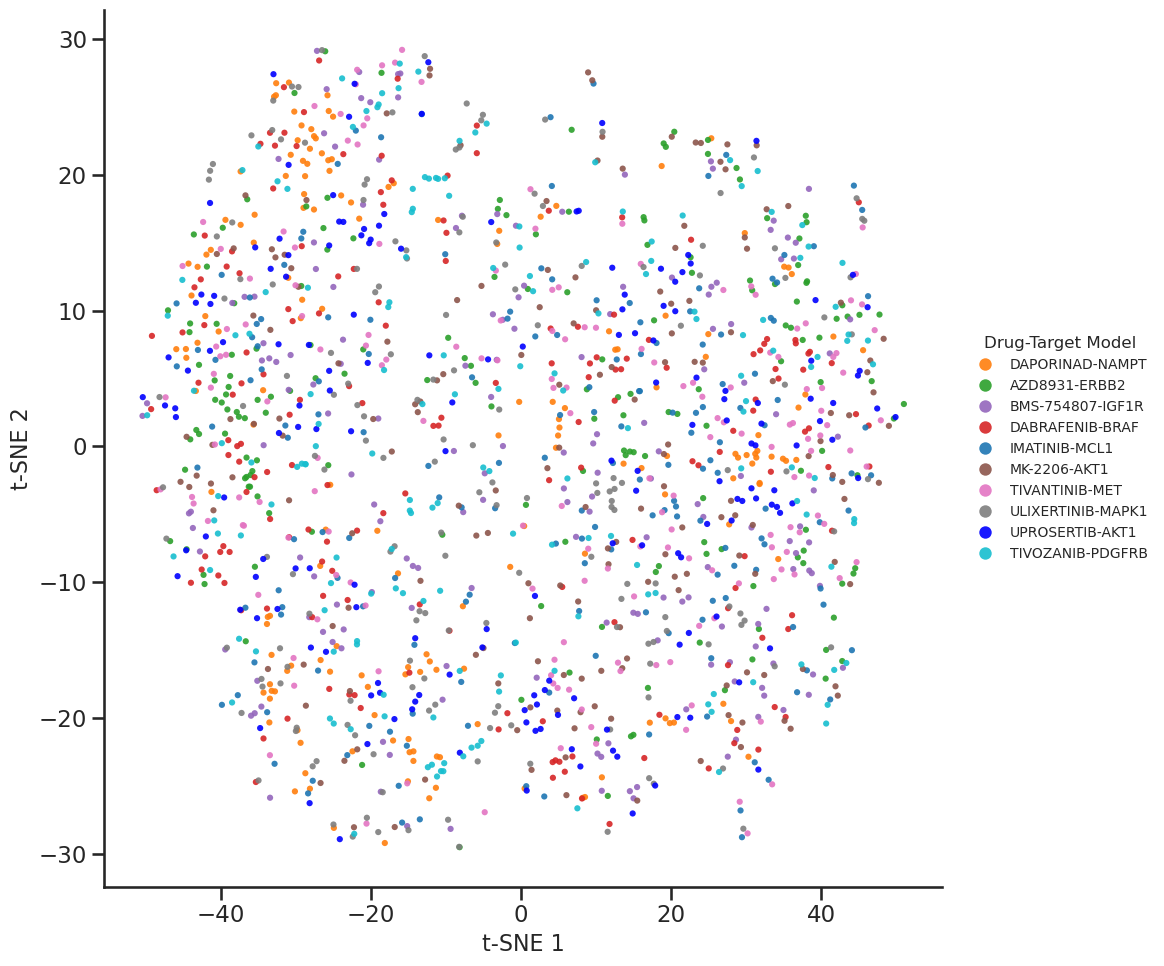

In [ ]:
# =============================================================================
# PART 4: t-SNE ON PCA-REDUCED DATA
# =============================================================================
print("\n" + "="*80)
print("Part 4: Running t-SNE on PCA-reduced data...")

from sklearn.manifold import TSNE

print("   Running t-SNE...")
tsne = TSNE(
    n_components=2,
    perplexity=25,        # ~5–50; depends on sample size
    learning_rate='auto',
    n_iter=1000,
    init='pca',           # best practice after PCA
    metric='cosine',      # matches your latent-space choice
    random_state=42,
    verbose=1
)

embedding = tsne.fit_transform(combined_Z)

tsne_df = pd.DataFrame(embedding, columns=['tSNE1', 'tSNE2'])


fig, ax = plt.subplots(figsize=(12, 10))

plot_df = tsne_df.copy()
plot_df['Model'] = all_labels

scatter = sns.scatterplot(
    data=plot_df,
    x='tSNE1',
    y='tSNE2',
    hue='Model',
    palette=palette,
    s=20,
    alpha=0.9,
    edgecolor='none',
    ax=ax
)

# Rasterize points (good for PDF)
scatter.collections[0].set_rasterized(True)

ax.set_xlabel('t-SNE 1', fontsize=16)
ax.set_ylabel('t-SNE 2', fontsize=16)

sns.despine(top=True, right=True)

# Legend (outside, clean)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title="Drug-Target Model",
    title_fontsize=12,
    fontsize=10,
    markerscale=2,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()
